# Reconocedor de mariposas


## Comprueba si se esta usando la GPU

In [4]:
import tensorflow as tf

# Verifica si TensorFlow tiene acceso a la GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f"Keras/TensorFlow tiene acceso a la GPU -> {tf.test.gpu_device_name()}")
else:
    print("Keras/TensorFlow está utilizando la CPU.")


Keras/TensorFlow tiene acceso a la GPU -> /device:GPU:0


## Importaciones necesarias y configuraciones previas

In [5]:
# IMPORTS --------------------------------------------------
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import os

# Establecer una semilla para reproducibilidad
seed_value = 42
random.seed(seed_value)        # Semilla para Python
np.random.seed(seed_value)     # Semilla para NumPy
tf.random.set_seed(seed_value) # Semilla para TensorFlow/Keras

## Data augmentation manual


In [6]:
'''
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directorio principal que contiene los subdirectorios con imágenes
directorio_principal = './Descargas/ButterflyMoths/train/'  # Cambia esto a la ruta de tu directorio
directorio_principal = './datasets/ButterflyMoths/train/'  # Cambia esto a la ruta de tu directorio

# Obtener la lista de subdirectorios
subdirectorios = [d for d in os.listdir(directorio_principal) if os.path.isdir(os.path.join(directorio_principal, d))]

# Iterar a través de los subdirectorios y mostrar la primera imagen de cada uno
for subdirectorio in subdirectorios:
    # Obtener la lista de archivos en el subdirectorio
    archivos = os.listdir(os.path.join(directorio_principal, subdirectorio))

    # Encontrar la primera imagen en el subdirectorio
    primera_imagen = None
    for archivo in archivos:
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            primera_imagen = archivo
            break

    # Mostrar la primera imagen si se encuentra
    if primera_imagen:
        ruta_imagen = os.path.join(directorio_principal, subdirectorio, primera_imagen)
        with Image.open(ruta_imagen) as img:
            plt.imshow(img)
            plt.title(f'Primera imagen en "{subdirectorio}"')
            plt.axis('off')
            plt.show()
    else:
        print(f"No se encontraron imágenes en el subdirectorio '{subdirectorio}'")
'''


'\nimport os\nfrom PIL import Image\nimport matplotlib.pyplot as plt\n\n# Directorio principal que contiene los subdirectorios con imágenes\ndirectorio_principal = \'./Descargas/ButterflyMoths/train/\'  # Cambia esto a la ruta de tu directorio\ndirectorio_principal = \'./datasets/ButterflyMoths/train/\'  # Cambia esto a la ruta de tu directorio\n\n# Obtener la lista de subdirectorios\nsubdirectorios = [d for d in os.listdir(directorio_principal) if os.path.isdir(os.path.join(directorio_principal, d))]\n\n# Iterar a través de los subdirectorios y mostrar la primera imagen de cada uno\nfor subdirectorio in subdirectorios:\n    # Obtener la lista de archivos en el subdirectorio\n    archivos = os.listdir(os.path.join(directorio_principal, subdirectorio))\n\n    # Encontrar la primera imagen en el subdirectorio\n    primera_imagen = None\n    for archivo in archivos:\n        if archivo.lower().endswith((\'.png\', \'.jpg\', \'.jpeg\', \'.gif\', \'.bmp\')):\n            primera_imagen = arc

## Data augmentation con generador

In [7]:

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras_preprocessing.image import load_img, img_to_array

'''
image_size = (224, 224) 
batch_size = 16

# Configuración del generador de aumento de datos
data_augmentation = ImageDataGenerator(
    rescale=1./255,                 # Normalización de los valores de píxeles
    rotation_range=40,              # Grados de rotación aleatoria
    width_shift_range=0.1,          # Desplazamiento horizontal aleatorio
    height_shift_range=0.1,         # Desplazamiento vertical aleatorio
    shear_range=0.1,                # Cizalla aleatoria
    zoom_range=0.1,                 # Rango de zoom aleatorio
    channel_shift_range=5,         # Cambios aleatorios en los canales de colores
    brightness_range=[0.8,1.2],     # Rango de brillo aleatorio
    horizontal_flip=True,           # Activar volteo horizontal
    vertical_flip=True,             # Activar volteo vertical
    fill_mode='nearest'             # Modo de llenado para cuando se aplican transformaciones espaciales
)

# Directorios de entrenamiento y validación
train_dir = './datasets/ButterflyMoths/train'
valid_dir = './datasets/ButterflyMoths/valid'

# Directorios de salida para las imágenes aumentadas
augmented_train_dir = './datasets/ButterflyMoths/augmented_train'
augmented_valid_dir = './datasets/ButterflyMoths/augmented_valid'

# Función para guardar las imágenes aumentadas
def save_augmented_images(directory, augmented_directory, generator, num_images_per_file=5):
    # Crear el directorio si no existe
    if not os.path.exists(augmented_directory):
        os.makedirs(augmented_directory)
    
    for subdir in os.listdir(directory):
        subdirectory = os.path.join(directory, subdir)
        if os.path.isdir(subdirectory):
            augmented_subdir = os.path.join(augmented_directory, subdir)
            if not os.path.exists(augmented_subdir):
                os.makedirs(augmented_subdir)
            
            for file in os.listdir(subdirectory):
                file_path = os.path.join(subdirectory, file)
                image_obj = load_img(file_path)
                image_array = img_to_array(image_obj)
                image_array = image_array.reshape((1,) + image_array.shape)
                
                # Generar nuevas imágenes
                i = 0
                for batch in generator.flow(image_array, batch_size=1, save_to_dir=augmented_subdir, save_prefix=subdir, save_format='jpeg'):
                    i += 1
                    if i >= num_images_per_file:
                        break  # Guardar 5 imágenes y luego continuar con la siguiente imagen

# Aplicar aumento de datos al conjunto de entrenamiento y validación
save_augmented_images(train_dir, augmented_train_dir, data_augmentation)
save_augmented_images(valid_dir, augmented_valid_dir, data_augmentation)


# Creación de los generadores
train_gen = data_augmentation.flow_from_directory(
    train_dir,
    target_size=image_size,  # Asegúrate de que coincida con el tamaño de entrada de tu modelo
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = data_augmentation.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
'''


"\nimage_size = (224, 224) \nbatch_size = 16\n\n# Configuración del generador de aumento de datos\ndata_augmentation = ImageDataGenerator(\n    rescale=1./255,                 # Normalización de los valores de píxeles\n    rotation_range=40,              # Grados de rotación aleatoria\n    width_shift_range=0.1,          # Desplazamiento horizontal aleatorio\n    height_shift_range=0.1,         # Desplazamiento vertical aleatorio\n    shear_range=0.1,                # Cizalla aleatoria\n    zoom_range=0.1,                 # Rango de zoom aleatorio\n    channel_shift_range=5,         # Cambios aleatorios en los canales de colores\n    brightness_range=[0.8,1.2],     # Rango de brillo aleatorio\n    horizontal_flip=True,           # Activar volteo horizontal\n    vertical_flip=True,             # Activar volteo vertical\n    fill_mode='nearest'             # Modo de llenado para cuando se aplican transformaciones espaciales\n)\n\n# Directorios de entrenamiento y validación\ntrain_dir = '

In [8]:
# DATA SOURCE --------------------------------------------------
# '''
image_size = (224, 224) 
batch_size = 16
data_dir = os.path.join('../datasets', 'fruit_classification', 'augmented_all')
train_dir = os.path.join('../datasets/ButterflyMoths/train') 
valid_dir = os.path.join('../datasets/ButterflyMoths/valid/') 
test_dir = os.path.join('../datasets/ButterflyMoths/test') 

train_dir = os.path.join('../datasets/ButterflyMoths/augmented_train/') 
valid_dir = os.path.join('../datasets/ButterflyMoths/augmented_valid/') 
test_dir = os.path.join('../datasets/ButterflyMoths/test') 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=valid_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)


train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
# '''

Found 8098 files belonging to 8 classes.
Found 2287 files belonging to 8 classes.
Found 90 files belonging to 8 classes.


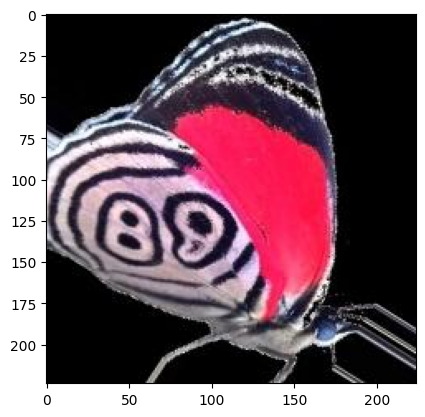

In [9]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

pil_im = Image.open('../datasets/ButterflyMoths/augmented_train/AN 88/AN 88_0_7.jpeg', 'r')
imshow(np.asarray(pil_im))



## Definición del modelo

In [10]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()

model.add(Rescaling(scale=1./255.0,
                    offset=-1,
                    input_shape=(224,224,3)))


model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])


## Training

In [39]:
epochs = 100

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds, # train_gen, 
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/100


507/507 [==============================] - 35s 68ms/step - loss: 0.0798 - accuracy: 0.9859 - val_loss: 0.2724 - val_accuracy: 0.9620
Epoch 2/100
507/507 [==============================] - 35s 69ms/step - loss: 0.0132 - accuracy: 0.9959 - val_loss: 0.4697 - val_accuracy: 0.9620
Epoch 3/100
507/507 [==============================] - 34s 68ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.1656 - val_accuracy: 0.9742
Epoch 4/100
507/507 [==============================] - 33s 66ms/step - loss: 2.9828e-05 - accuracy: 1.0000 - val_loss: 0.1634 - val_accuracy: 0.9751
Epoch 5/100
507/507 [==============================] - 32s 62ms/step - loss: 5.1593e-06 - accuracy: 1.0000 - val_loss: 0.1639 - val_accuracy: 0.9760
Epoch 6/100
507/507 [==============================] - 33s 66ms/step - loss: 4.1192e-06 - accuracy: 1.0000 - val_loss: 0.1644 - val_accuracy: 0.9755
Epoch 7/100
507/507 [==============================] - 36s 71ms/step - loss: 3.4125e-06 - accuracy: 1.0000 - val_loss: 0.1649 - va

## Graphical representation of results

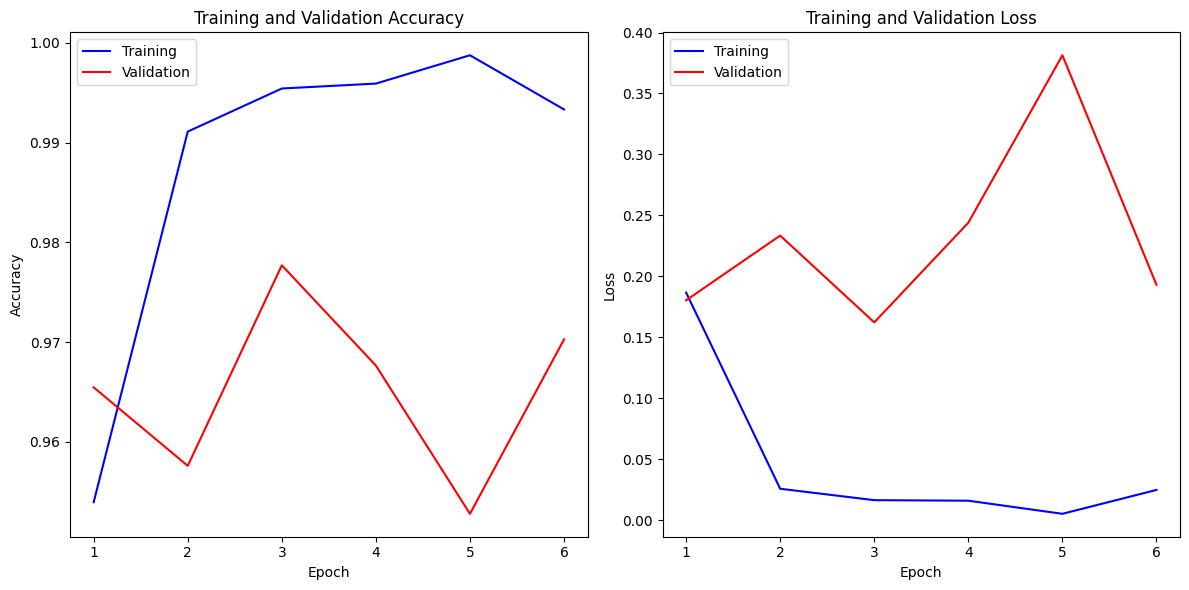

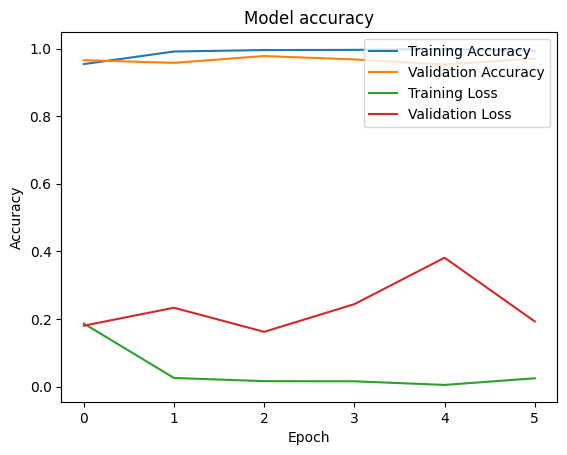

In [38]:
import matplotlib.pyplot as plt

def separate_plot(h):
    # Extracción de datos
    acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def combined_plot(h):
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('Model accuracy')    
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Accuracy', 'Validation Accuracy','Training Loss','Validation Loss'], loc='upper right')
    plt.show()

#------------------------------------------------------------------------
# Generate separate results plot
separate_plot(h)

# Generate combined results plot
combined_plot(h)





## Evaluation of results

Found 8098 files belonging to 8 classes.
1/1 [==============================] - 0s 16ms/step


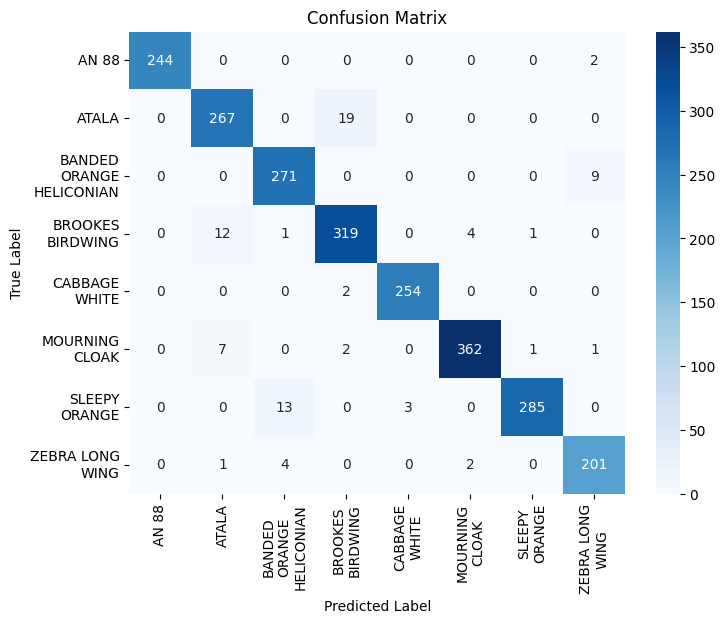

                          precision    recall  f1-score   support

                   AN 88     1.0000    0.9919    0.9959       246
                   ATALA     0.9303    0.9336    0.9319       286
BANDED
ORANGE
HELICONIAN     0.9377    0.9679    0.9525       280
        BROOKES
BIRDWING     0.9327    0.9466    0.9396       337
           CABBAGE
WHITE     0.9883    0.9922    0.9903       256
          MOURNING
CLOAK     0.9837    0.9705    0.9771       373
           SLEEPY
ORANGE     0.9930    0.9468    0.9694       301
         ZEBRA LONG
WING     0.9437    0.9663    0.9549       208

                accuracy                         0.9633      2287
               macro avg     0.9637    0.9645    0.9639      2287
            weighted avg     0.9637    0.9633    0.9634      2287



In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory

def split_labels(labels, max_length):
    """
    Format long labels by adding line breaks.

    Args:
    labels (list of str): Original list of labels.
    max_length (int): Maximum line length in a label.

    Returns:
    list of str: Labels with line breaks added.
    """
    formatted_labels = []
    for label in labels:
        if len(label) <= max_length:
            formatted_labels.append(label)
            continue

        # Split label into words and construct new label with line breaks
        words = label.split()
        new_label = words[0]
        for word in words[1:]:
            if len(new_label + ' ' + word) <= max_length:
                new_label += ' ' + word
            else:
                new_label += '\n' + word
        formatted_labels.append(new_label)
    
    return formatted_labels


def evaluate_model(train_dir, model, val_ds, max_label_length=15):
    """
    Function to evaluate a model with a validation dataset.
    Displays the confusion matrix and classification report.

    Args:
    train_dir (str): Training data directory to load class names.
    model (keras.Model): Model to evaluate.
    val_ds (tf.data.Dataset): Validation dataset.
    max_label_length (int): Maximum allowed label length before splitting at word boundaries.
    """
    # Load class names and plit long labels at word boundaries
    class_names = split_labels(labels=image_dataset_from_directory(directory=train_dir).class_names,
                               max_length= max_label_length)
    
    # Generate predictions and true labels
    results = np.concatenate([(y.numpy(), model.predict(x)) for x, y in val_ds], axis=1)
    predictions = np.argmax(results[1], axis=1)
    labels = np.argmax(results[0], axis=1)

    # Calculate the confusion matrix with formatted labels
    cf_matrix = confusion_matrix(labels, predictions)

    # Create a heatmap for the confusion matrix with formatted labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues",
                          xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Display the classification report with formatted labels
    formatted_labels = split_labels(class_names, max_label_length)
    formatted_classification_report = classification_report(labels, predictions, target_names=formatted_labels, digits=4)
    print(formatted_classification_report)

# Example usage:
evaluate_model(train_dir, model, val_ds, max_label_length=11)


# VGG16 (Visual Geometry Group) CNN-Net

## Required imports and previous configuration

In [34]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

## Test prediction with model

In [34]:
decode_predictions(np.expand_dims(np.arange(1000), 0), top=1000)


img = image.load_img('../datasets/ButterflyMoths/augmented_train/AN 88/AN 88_0_7.jpeg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)
results = decode_predictions(features, top=5)
print(results)

1/1 [==============================] - 1s 855ms/step
[[('n02281787', 'lycaenid', 0.5069278), ('n01833805', 'hummingbird', 0.038628694), ('n02259212', 'leafhopper', 0.036325745), ('n03929660', 'pick', 0.025240205), ('n03759954', 'microphone', 0.018303815)]]


## Model configuration and training

**Explanation of "Inference Mode"**

When it's said that the "base model is in inference mode," it means that the model is being used for making predictions (inferences) rather than for training. This is important when using a pretrained model and only wanting to fine-tune the last layers without modifying the previously learned weights in the earlier layers.

In TensorFlow and Keras, this is achieved by setting `training=False` when calling the base model. This way, the model won't update its weights during the backpropagation process, preserving the previously learned weights.

**Other Modes:**

1. **Training Mode**: This is when `training=True`. In this mode, all training-related operations, such as gradient computation and weight updates, are active.

2. **Inference Mode**: `training=False` indicates that the model is being used to make predictions. Training-specific operations like dropout or batch normalization layers behave differently in this mode to reflect that the model is not being trained.

Using the correct mode is crucial for achieving the expected results, especially when working with pretrained models and performing fine-tuning.

In [35]:
from tensorflow.keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

# Load the VGG16 model pre-trained on ImageNet data
base_model = VGG16(
    weights='imagenet', 
    input_shape=(224, 224, 3),
    include_top=False)  # Exclude the top (fully connected) layers

# Set the VGG16 model to be non-trainable to retain the pre-trained weights
base_model.trainable = False

# Define the input layer
input_layer = keras.Input(shape=(224, 224, 3))

# Use the base model as a feature extractor
# Ensure the base_model runs in inference mode, important for fine-tuning, as
feature_vector = base_model(input_layer, training=False)

# Add GlobalAveragePooling2D layer to reduce feature map size
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(feature_vector)

# Add Dense layer to interpret the features
dense_layer = keras.layers.Dense(256, activation='relu')(global_avg_pooling)

# Output layer for classification into 8 classes
output_layer = keras.layers.Dense(8, activation='softmax')(dense_layer)

# Create the final model
model_with_VGG16 = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_with_VGG16.compile(loss='categorical_crossentropy',
                         optimizer=keras.optimizers.Adam(1e-3),
                         metrics=['accuracy'])

# Set the number of epochs for training
epochs = 10

# Early stopping to monitor the validation accuracy and stop training when it starts to decrease
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3, restore_best_weights=True)

# Train the model with the training and validation data
h_vgg16 = model_with_VGG16.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es]
)


## Evaluation of results

In [2]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Call to evaluate model function -> Confusion matrix and classification report
evaluate_model(train_dir, model_with_VGG16, val_ds, max_label_length=11)


NameError: name 'evaluate_model' is not defined

# VGG19 (Visual Geometry Group) CNN-Net

In [40]:
from tensorflow.keras.applications import VGG19
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

# Load the VGG19 model pre-trained on ImageNet data
base_model = VGG19(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)  # Exclude the top (fully connected) layers

# Set the VGG19 model to be non-trainable to retain the pre-trained weights
base_model.trainable = False

# Define the input layer
input_layer = keras.Input(shape=(224, 224, 3))

# Use the base model as a feature extractor
# Ensure the base_model runs in inference mode, important for fine-tuning
feature_vector = base_model(input_layer, training=False)

# Add GlobalAveragePooling2D layer to reduce feature map size
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(feature_vector)

# Add Dense layer to interpret the features
dense_layer = keras.layers.Dense(256, activation='relu')(global_avg_pooling)

# Output layer for classification into 8 classes
output_layer = keras.layers.Dense(8, activation='softmax')(dense_layer)

# Create the final model
model_with_VGG19 = keras.Model(inputs=input_layer, outputs=output_layer)
model_with_VGG19.compile(loss='categorical_crossentropy',
                         optimizer=keras.optimizers.Adam(1e-3),
                         metrics=['accuracy'])

# Set the number of epochs for training
epochs = 10

# Early stopping to monitor the validation accuracy and stop training when it starts to decrease
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3, restore_best_weights=True)

# Train the model with the training and validation data
h_vgg19 = model_with_VGG19.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es]
)


NameError: name 'input_layer' is not defined

## Evaluation of results

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Call to evaluate model function -> Confusion matrix and classification report
evaluate_model(train_dir, model_with_VGG19, val_ds, max_label_length=11)


# ResNet50 (Residual Neural Network) CNN-Net

In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)  # Exclude the top (fully connected) layers

# Set the ResNet50 model to be non-trainable to retain the pre-trained weights
base_model.trainable = False

# Define the input layer
input_layer = Input(shape=(224, 224, 3))

# Use the base model as a feature extractor: Setting training=False ensures that it operates in inference mode.
feature_vector = base_model(input_layer, training=False)

# Add GlobalAveragePooling2D layer to reduce feature map size
pooled_features = GlobalAveragePooling2D()(feature_vector)

# Add Dense layer to interpret the features
dense_layer = Dense(256, activation='relu')(pooled_features)

# Output layer for classification into 8 classes
output_layer = Dense(8, activation='softmax')(dense_layer)

# Create the final model
model_resnet50 = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy'])

# Set the number of epochs for training
epochs = 10

# Early stopping to monitor the validation accuracy and stop training when it starts to decrease
es_callback = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3, restore_best_weights=True)

# Train the model with the training and validation data
history_resnet50 = model_resnet50.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es_callback]
)


94765736/94765736 [==============================] - 4s 0us/step


NameError: name 'train_ds' is not defined